In [1]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=d74740d8e802dae03c013bcdf8d9a69cbc61c3bd7820f86bc9956a85f1ca06ca
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling as yd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer

In [79]:
# Import data
financial_inclusion_dataset= pd.read_csv("Financial_inclusion_dataset.csv")
financial_inclusion_dataset= financial_inclusion_dataset.drop(["uniqueid"], axis=1)
financial_inclusion_dataset.head()

,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
# Quick overview
financial_inclusion_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   bank_account            23524 non-null  object
 3   location_type           23524 non-null  object
 4   cellphone_access        23524 non-null  object
 5   household_size          23524 non-null  int64 
 6   age_of_respondent       23524 non-null  int64 
 7   gender_of_respondent    23524 non-null  object
 8   relationship_with_head  23524 non-null  object
 9   marital_status          23524 non-null  object
 10  education_level         23524 non-null  object
 11  job_type                23524 non-null  object
dtypes: int64(3), object(9)
memory usage: 2.2+ MB


In [6]:
# Pandas profiling
profile = yd.ProfileReport(financial_inclusion_dataset)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [80]:
# Handle duplicates
no_dupes= financial_inclusion_dataset.drop_duplicates()

In [81]:
# Missing values
no_dupes.isnull().sum()

,0
country,0
year,0
bank_account,0
location_type,0
cellphone_access,0
household_size,0
age_of_respondent,0
gender_of_respondent,0
relationship_with_head,0
marital_status,0


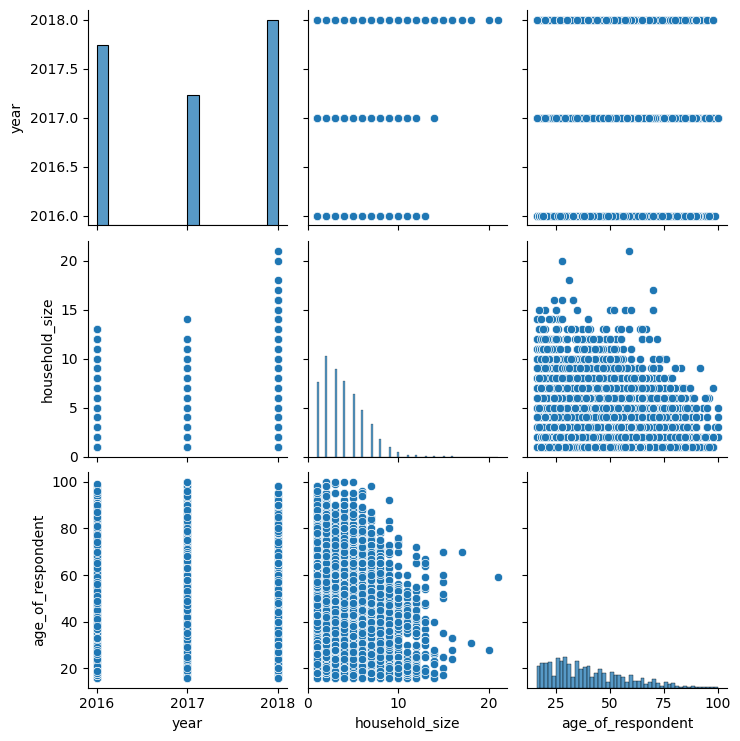

In [11]:
# Pairplot for numerical variables
num_cols= no_dupes.select_dtypes(include=np.number).columns
sns.pairplot(no_dupes[num_cols])

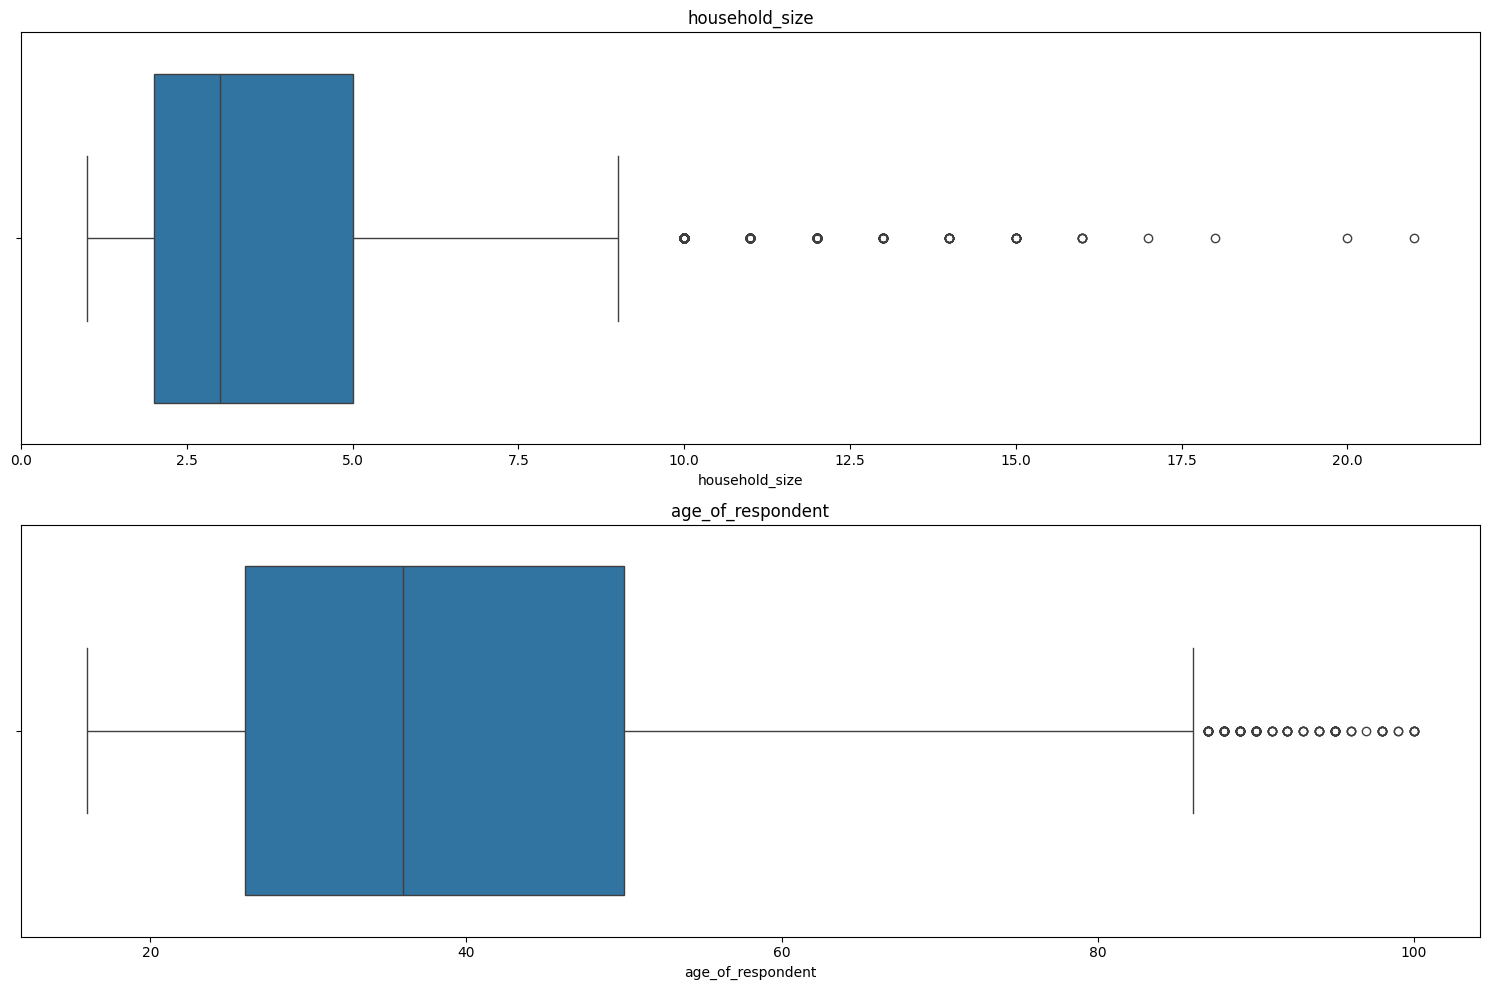

In [19]:
# Boxplots of num_cols

def sub_boxplots(data, features, rows=2):
  fig, axes = plt.subplots(nrows=rows, ncols=int(np.ceil((len(features)/3))), figsize=(15, 10))
  axes = axes.flatten()
  for i, col in enumerate(features):
      sns.boxplot(x=data[col], ax=axes[i])
      axes[i].set_title(col)
  plt.tight_layout()
  plt.show()

sub_boxplots(no_dupes, [col for col in num_cols if col != "year"])
# It's reasonable for families to have 20 members if unlikely
# It's also reasonable for some individuals to live up to 100

In [26]:
no_dupes["bank_account"].value_counts(normalize=True)
# Imbalaced target variable

,proportion
bank_account,
No,0.834774
Yes,0.165226


In [82]:
# Select target and features

# Target
clean_data= no_dupes.copy()
clean_data["bank_account"]= clean_data["bank_account"].map({"Yes": 1, "No": 0})
y= clean_data["bank_account"]

# Features
X= clean_data.drop(["bank_account"], axis=1)

# Train test split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, stratify= y,random_state=42)

In [83]:
# Pipeline setup

# Build preprocessor
preprocessor= ColumnTransformer(
    transformers= [
        ("OneHotEncoder", OneHotEncoder(handle_unknown="ignore"), ["country", "year", "location_type", \
                                                                   "cellphone_access", "gender_of_respondent",\
                                                                   "relationship_with_head", "marital_status", "job_type"]),
        ("LabelEncoder", OrdinalEncoder(), ["education_level"]),
    ])

In [84]:
# Build pipeline
pipeline= Pipeline(
    steps= [
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBClassifier())
    ]
)

In [85]:
# Use XGBoost as it performs well with wide and sparse data

# XGBoost params grid
param_grid= {
    "classifier": [xgb.XGBClassifier()],
    "classifier__learning_rate": [0.01, 0.1, 0.5],
    "classifier__max_depth": [3, 5, 7],
    "classifier__n_estimators": [100, 200, 300],
}

In [68]:
# Gridsearch
from sklearn.model_selection import GridSearchCV
grid_search= GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['country',
                                                                          'year',
                                                                          'location_type',
                                                                          'cellphone_access',
                                                                          'gender_of_respondent',
                                                                          'relationship_with_head',
                                                                          'marital_status',
                                                                          'job_type']),
                                                                        ('LabelEncoder',
                                                                         OrdinalEncoder(),
                                                                         ['education_level'])])),
                                       ('classifier',...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...)],
                         'classifier__learning_rate': [0.01, 0.1, 0.5],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [69]:
# Evaluate model
best_model= grid_search.best_estimator_
y_pred= best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.93      3188
           1       0.71      0.34      0.46       631

    accuracy                           0.87      3819
   macro avg       0.80      0.66      0.69      3819
weighted avg       0.85      0.87      0.85      3819



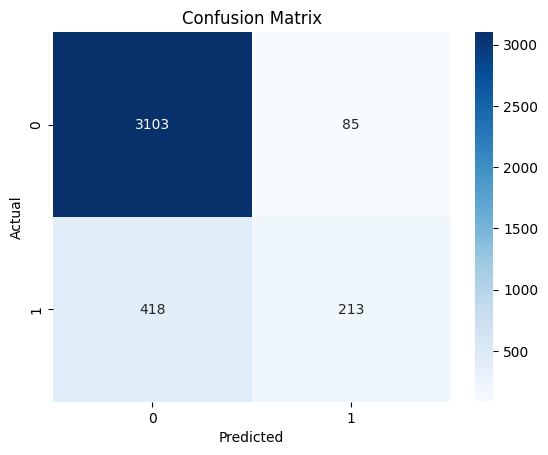

In [70]:
# Visualise conf matrix
conf_matrix= confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

country 	0
year 	0
bank_account 	0
location_type 	0
cellphone_access 	0
household_size 	0
age_of_respondent 	0
gender_of_respondent 	0
relationship_with_head 	0
marital_status 	0
education_level 	0
job_type

In [76]:
# Extract categorical variables and their respective categories in dict
cat_cols= ["country", "year", "location_type", "cellphone_access", "gender_of_respondent", "relationship_with_head",\
 "marital_status", "job_type", "education_level"]
cat_dict= {col: X_train[col].unique() for col in cat_cols}

In [77]:
# Save model and categories as pkl
import pickle
import joblib
joblib.dump(best_model, "model.pkl")
joblib.dump(cat_dict, "cat_dict.pkl")

['cat_dict.pkl']